# **VARIETY SAMPLING FUNCTION PROJECT**
Dinh Long Huynh



## **Function annotation:**

The function performs PCA decomposition and selects specific data points based on their distance from the origin point on the PCA coordinate system. This is called primary selection. Additionally, the function offers secondary data selection, which is based on the distance of every primary point to every remaining observation in the dataset.



### **Primary Selection:**

The function takes in a preprocess dataframe and performs PCA decomposition with a manually specified number of components. It then calculates the distance of each data point to the origin point on the PCA coordinate system and uses this metric to select certain data points. All observations are classified by a combination of the signs of all principal components (-1 or 1). For each class, a certain number of maximum distance points are chosen as corner points. Additionally, a certain number of minimum distance points are chosen as center points. 

Primary Selection work well for the sphere data, but poor for the skewd data, where the secondary selection come into play.

### **Secondary Selection:**

Also based on PCA space, Secondary Selection computes the distance between every possible combination of primary points and remaining observations (pairwise distance). It then applies a filter to the distances based on a user-defined threshold value. This value should be appropriate the create a speard data. Finally, gor each primary point, the observation with the minimum distance to it is selected.


### **Arguments:**

    1) df_prep: a preprocessed dataset that filters out features requiring PCA decomposition.

    2) n_components (int): number of PCs

    3) n_obs_each_corner (int): number of observation on each corner of factorial desgin.

    4) n_center_point (int): number of center points.

    5) second_select (boolean): activate secondary selection.
    
    6) distance_threshold (float): threshold used for filtering pairwise distance.

# **1. REQUIRED LIBRARIES**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler
import math

# **2. BUILD THE FUNCTION** 

In [40]:
def variety_selection_pca_based(data, n_components=2, n_obs_each_corner=1, n_center_point=1, 
                                second_select = False, distance_threshold = 2, random_state=42)

    # Standardize data
    data_standard = StandardScaler().fit_transform(data)
    
    # PCA transformation of data
    global df_pca
    pca = PCA(n_components=n_components, random_state=random_state)
    df_pca = pca.fit_transform(data_standard)
    df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(n_components)], index = data.index)
    
    # Calculate distance to origin point on PCA space
    df_pca['Distance'] = np.sqrt((df_pca ** 2).sum(axis=1))
    
    # Create sign columns
    for column in df_pca.columns[:-1]:
        df_pca[f'sign_{column}'] = np.sign(df_pca[column])
    
    # Group data by sign columns and choose n_maxmum points of each group
    sign_columns = [column for column in df_pca.columns if column.startswith('sign_')]

    max_index = df_pca.groupby(sign_columns)['Distance'].nlargest(n_obs_each_corner).index.get_level_values(-1)

    # Choose points that have minimum distance as center points
    min_index = df_pca['Distance'].nsmallest(n_center_point).index.get_level_values(-1)

    # Generate index for training set that need to be extracted
    global first_index
    first_index = pd.Index(np.concatenate([max_index, min_index]))
    df_train_1st = data.loc[first_index]
    df_test_1st = data.drop(df_train_1st.index)
    
    # The optional secondary data selection:
    if second_select:

        # Divided PCA data and filter only PCA scores column
        df_train_pca = df_pca.loc[first_index].filter(regex='^PC')
        df_test_pca = df_pca.drop(df_train_pca.index).filter(regex='^PC')

        # Calculate the pairwise PCA scores substraction of each point in df_train_pca to each point in df_test_pca
        rows_list = []
        for train_index in df_train_pca.index:
            for test_index in df_test_pca.index:
                # Calculate pair-wise subtraction as a NumPy array (optimized calculation time)
                diff_array = df_test_pca.loc[test_index].values - df_train_pca.loc[train_index].values
        
                # Create a dictionary with train_index, test_index, and differences. Prepare for multiindex DataFrame
                diff_data = {'Train_Index': train_index, 'Test_Index': test_index}
                diff_data.update({f'{col}_diff': val for col, val in zip(df_test_pca.columns, diff_array)})
        
                # Append the dictionary to the rows_list
                rows_list.append(diff_data)

        # Convert the list of dictionaries to a DataFrame
        pairwise_df = pd.DataFrame(rows_list)

        # Set the desired indexes
        pairwise_df.set_index(['Train_Index', 'Test_Index'], inplace=True)
        
        # Calculate distance base on PCA scores substraction
        pairwise_df['Distance'] = np.sqrt((pairwise_df**2).sum(axis=1))

        # Filtered by the desirable distance threshold
        pairwise_df_threshold = pairwise_df[pairwise_df['Distance'] >= distance_threshold]

        # Take the secondary index by choosing the points that have minium distance to corresponding primary points.
        pairwise_df_min = pairwise_df_threshold.groupby(level=0)['Distance'].agg([('Min_Distance', 'min'), ('Test_Index', lambda x: x.idxmin()[1])])
        global second_index
        index=pairwise_df_min['Test_Index']
        second_index = index.to_list()

        # Extract corresponding index, returns dataframes
        secondary_train_df = df_test_1st.loc[second_index]
        total_train_df = pd.concat([df_train_1st,secondary_train_df])
        total_test_df = data.drop(total_train_df.index)
        return total_train_df, total_test_df
    
    # Return primary dataframe
    else:
        return df_train_1st, df_test_1st
    

# **3. DEMO USE**

In [69]:
# Import the file path
file_path = 'sample_data.csv'

df = pd.read_csv(file_path)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10019 entries, 0 to 10018
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         10019 non-null  int64  
 1   SMILE              10019 non-null  object 
 2   ID                 10019 non-null  object 
 3   MOL                10019 non-null  object 
 4   Activity           10019 non-null  int64  
 5   MolLogP            10019 non-null  float64
 6   MolWt              10019 non-null  float64
 7   HBD                10019 non-null  int64  
 8   HBA                10019 non-null  int64  
 9   NumAromaticRings   10019 non-null  int64  
 10  NumRotatableBonds  10019 non-null  int64  
 11  TPSA               10019 non-null  float64
 12  MolMR              10019 non-null  float64
 13  BertzCT            10019 non-null  float64
 14  BalabanJ           10019 non-null  float64
 15  FpDensityMorgan1   10019 non-null  float64
 16  FpDensityMorgan2   100

In [70]:
# Fill the features that you want to do the PCA
feature_list = ['MolLogP','MolWt','HBD','HBA','NumAromaticRings','NumRotatableBonds','BalabanJ','BertzCT','HeavyAtomCount','FpDensityMorgan1','FractionCSP3','TPSA','MolMR']

df_prep = df[feature_list]

In [71]:
# Demo use
df_train, df_test = variety_selection_pca_based(data=df_prep, 
                                                n_components=2, 
                                                n_obs_each_corner=2,
                                                n_center_point=2, 
                                                second_select=True,
                                                distance_threshold=2)
df_train

,MolLogP,MolWt,HBD,HBA,NumAromaticRings,NumRotatableBonds,BalabanJ,BertzCT,HeavyAtomCount,FpDensityMorgan1,FractionCSP3,TPSA,MolMR
1759,7.12380,384.482,0,2,5,4,1.301115,1270.904044,30,0.400000,0.000000,25.78,127.7840
8768,6.44114,497.572,0,5,5,5,1.735664,1765.394109,36,0.805556,0.103448,84.66,140.0778
1200,5.73456,544.592,1,9,5,8,1.417816,1871.553030,40,0.950000,0.064516,143.00,151.8279
2872,3.32120,565.677,2,9,4,11,1.424291,1528.848603,39,0.846154,0.185185,146.39,149.0559
9077,0.34230,101.149,1,2,0,0,2.399707,62.480406,7,1.571429,1.000000,21.26,28.0337
5134,1.12518,111.144,0,2,0,2,3.440210,120.980450,8,1.750000,0.666667,40.86,30.0750
8500,-0.39740,140.160,2,3,0,1,4.534785,160.212669,8,1.375000,1.000000,74.60,27.8464
4601,-0.15810,104.105,2,2,0,1,3.791118,79.425922,7,1.571429,0.750000,57.53,23.9336
3200,3.05404,363.389,1,4,2,3,1.828106,873.211731,25,1.320000,0.235294,62.30,91.7757
6892,2.90660,327.336,1,5,2,3,1.867697,817.296686,24,1.041667,0.277778,66.02,87.2007


# **4. TEST FUNCTION**

Four scenarios were chosen to test the function: 

1) Only using primary selection for picking small number of data points
2) Only using primary selection for picking large number of data points
3) Using primary-secondary selection for picking small number of data points
4) Using primary-secondary selection for picking large number of data points

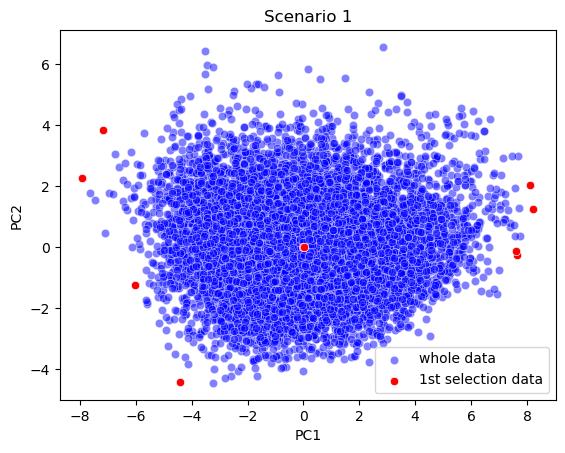

In [72]:
# Scenario 1: Only using primary selection for picking small number of data points
df_train, df_test = variety_selection_pca_based(data=df_prep, 
                                                n_components=2, 
                                                n_obs_each_corner=2,
                                                n_center_point=2, random_state=42)

df_pca_train = df_pca.loc[first_index]

sns.scatterplot(x='PC1',y='PC2',data=df_pca,color='blue',label='whole data',alpha=0.5)
sns.scatterplot(x='PC1',y='PC2',data=df_pca_train,color='red',label='1st selection data')
plt.title('Scenario 1')
plt.legend()
plt.show()

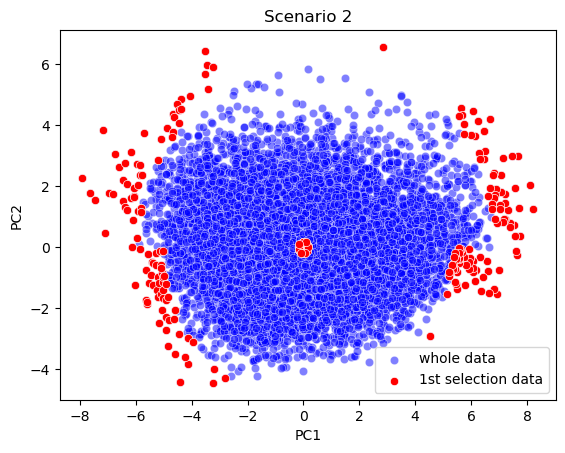

In [73]:
# Scenario 2: Only using primary selection for picking large number of data points
df_train, df_test = variety_selection_pca_based(data=df_prep, 
                                                n_components=2, 
                                                n_obs_each_corner=50,
                                                n_center_point=50, random_state=42)

df_pca_train = df_pca.loc[first_index]

sns.scatterplot(x='PC1',y='PC2',data=df_pca,color='blue',label='whole data',alpha=0.5)
sns.scatterplot(x='PC1',y='PC2',data=df_pca_train,color='red',label='1st selection data')
plt.title('Scenario 2')
plt.legend()
plt.show()

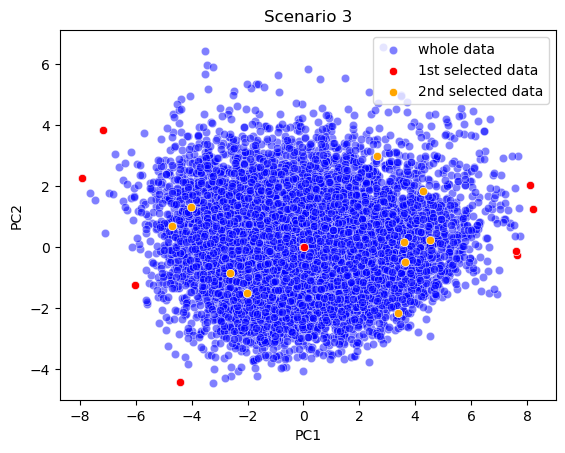

In [74]:
# Scenario 3: Using primary-secondary selection for picking small number of data points
df_train, df_test = variety_selection_pca_based(data=df_prep, 
                                                n_components=2, 
                                                n_obs_each_corner=2,
                                                n_center_point=2, 
                                                second_select=True, 
                                                distance_threshold=4, random_state=43)

df_pca_train = df_pca.loc[first_index]
df_pca_secondary_train = df_pca.loc[second_index]

sns.scatterplot(x='PC1',y='PC2',data=df_pca,color='blue',label='whole data',alpha=0.5)
sns.scatterplot(x='PC1',y='PC2',data=df_pca_train,color='red',label='1st selected data')
sns.scatterplot(x='PC1',y='PC2',data=df_pca_secondary_train,color='orange',label='2nd selected data')
plt.title('Scenario 3')
plt.legend()
plt.show()

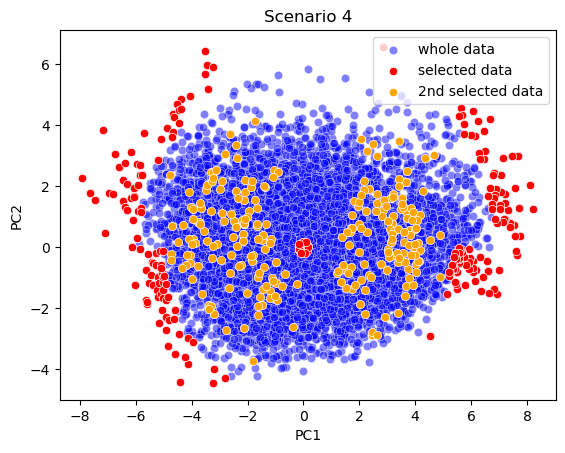

In [75]:
# Scenario 4: Using primary-secondary selection for picking large number of data points
df_train, df_test = variety_selection_pca_based(data=df_prep, 
                                                n_components=2, 
                                                n_obs_each_corner=50,
                                                n_center_point=50, 
                                                second_select=True, 
                                                distance_threshold=4, random_state=43)

df_pca_train = df_pca.loc[first_index]
df_pca_secondary_train = df_pca.loc[second_index]

sns.scatterplot(x='PC1',y='PC2',data=df_pca,color='blue',label='whole data',alpha=0.5)
sns.scatterplot(x='PC1',y='PC2',data=df_pca_train,color='red',label='selected data')
sns.scatterplot(x='PC1',y='PC2',data=df_pca_secondary_train,color='orange',label='2nd selected data')
plt.title('Scenario 4')
plt.legend()
plt.show()